In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import numpy as np

# Download stopwords

In [13]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bbuser\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Step 1: Data Preprocessing


In [14]:
# load the d dataset 
df = pd.read_json("News_Category_Dataset_v3.json", lines=True)

# Keep only  the selected categories( politics, travel, sports, home and living)
categories = ["POLITICS", "TRAVEL", "SPORTS", "HOME & LIVING"]
df = df[df["category"].isin(categories)][["short_description", "category"]]

# Balance dataset (1000 per category)
df_balanced = df.groupby("category").apply(lambda x: x.sample(1000, random_state=42)).reset_index(drop=True)

# Stratified 80/20 split
train_df, test_df = train_test_split(
    df_balanced,
    test_size=0.2,
    stratify=df_balanced["category"],
    random_state=42
)

print("Train size:", train_df.shape, " Test size:", test_df.shape)


Train size: (3200, 2)  Test size: (800, 2)


C:\Users\bbuser\AppData\Local\Temp\ipykernel_7556\1283003662.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby("category").apply(lambda x: x.sample(1000, random_state=42)).reset_index(drop=True)


# Step 2: Word Frequency & Word Clouds


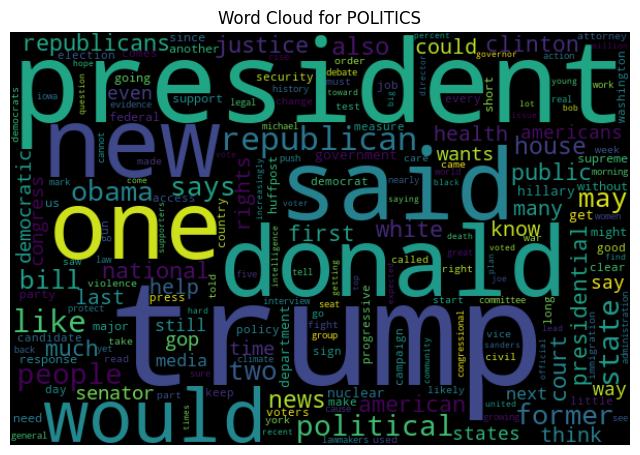

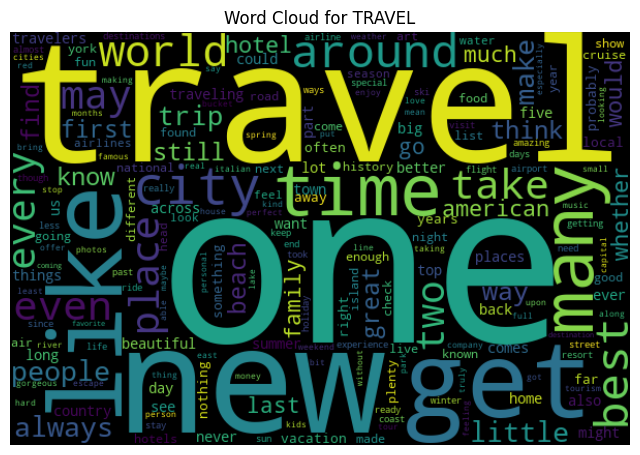

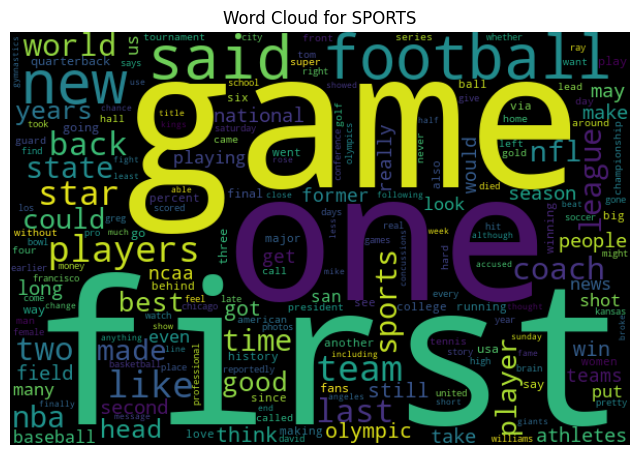

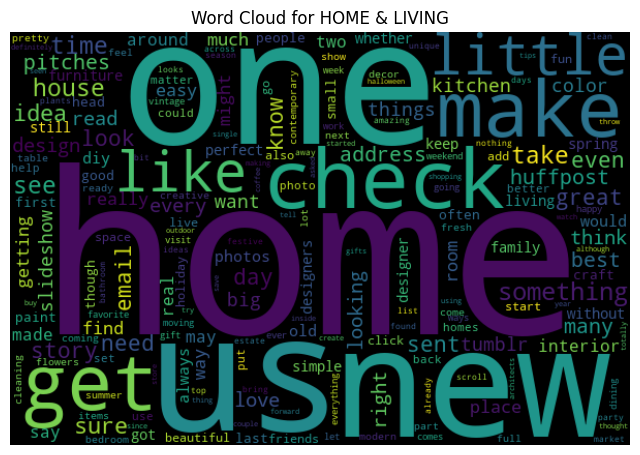

In [15]:
category_word_counts = {}

for cat in categories:
    text = " ".join(train_df[train_df["category"] == cat]["short_description"].str.lower())
    words = [w for w in text.split() if w.isalpha() and w not in stop_words]
    counts = Counter(words)
    category_word_counts[cat] = counts

    # Word Cloud
    wc = WordCloud(width=600, height=400, background_color="Black", stopwords=stop_words)
    wc.generate_from_frequencies(counts)
    plt.figure(figsize=(8,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for {cat}")
    plt.show()

# Helper: get top-N frequent words
def get_top_words(counts, n):
    return set([w for w, _ in counts.most_common(n)])

# Step 3: Keyword-Based Classifier


In [16]:
def keyword_classifier(text, category_keywords):
    words = [w for w in text.lower().split() if w.isalpha() and w not in stop_words]
    overlaps = {cat: len(set(words) & kw_set) for cat, kw_set in category_keywords.items()}
    
    # Assign category with highest overlap
    max_overlap = max(overlaps.values())
    if max_overlap == 0:
        return "unknown"
    best = [cat for cat, val in overlaps.items() if val == max_overlap]
    return best[0] if len(best) == 1 else "unknown"

# Step 4: Experimentation


In [17]:
results = []

for top_n in [10, 20, 30, 50, 100]:
    # Build keyword sets for each category
    category_keywords = {cat: get_top_words(category_word_counts[cat], top_n) for cat in categories}
    
    # Classify test set
    y_true = test_df["category"].tolist()
    y_pred = [keyword_classifier(txt, category_keywords) for txt in test_df["short_description"]]
    
    # Compute accuracy
    correct = sum(1 for yt, yp in zip(y_true, y_pred) if yt == yp)
    acc = correct / len(y_true)
    results.append((top_n, acc))
    print(f"Top {top_n} words → Accuracy: {acc:.3f}")

Top 10 words → Accuracy: 0.168
Top 20 words → Accuracy: 0.216
Top 30 words → Accuracy: 0.221
Top 50 words → Accuracy: 0.254
Top 100 words → Accuracy: 0.318


# Step 5: Plot Results


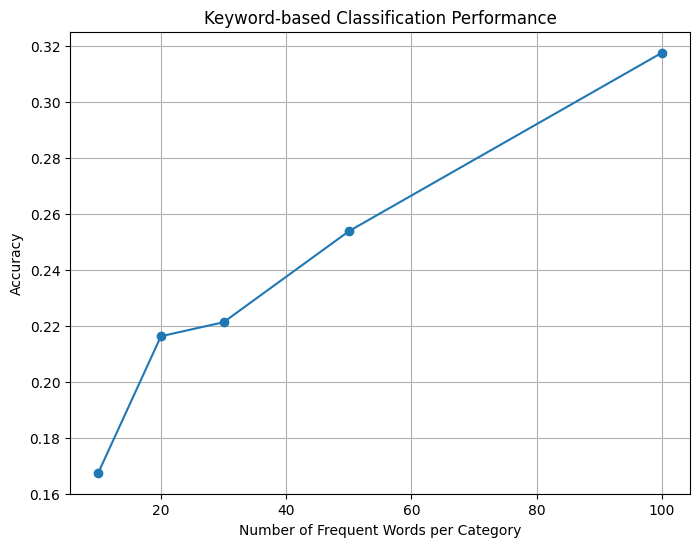

In [18]:
xs, ys = zip(*results)
plt.figure(figsize=(8,6))
plt.plot(xs, ys, marker="o")
plt.xlabel("Number of Frequent Words per Category")
plt.ylabel("Accuracy")
plt.title("Keyword-based Classification Performance")
plt.grid(True)
plt.show()
